# JAX Interior Point Method

This notebook begins to build an interior point method using Jax.

Jax makes gradient calculation easy and enables us to use hardware acceleration (GPU) for our IPM algorithm.

Let's start with a very simple linear programme and use JAX to solve it using IPM.

### Simplest example

    max x_1 + x_2
    s.t.
        2 * p * x_1 + x_2 <= p^2 + 1
    for all p in range(0,1,0.1)

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e2/Karmarkar.svg/400px-Karmarkar.svg.png">

Solve with scipy first in the form:
  
    minimize c @ x
    s.t.
        A_ub @ x <= b_ub 
        A_eq @ x == b_eq
        lb <= x <= ub

### Start with Scipy and np

In [1]:
import numpy as np
from scipy.optimize import linprog

In [2]:
b_ub = np.arange(0,1.,0.1)**2+1

In [3]:
A_ub = np.stack([np.array([2.*p,1.]) for p in np.arange(0,1,0.1)])

In [4]:
c = np.array([-1.,-1.])

In [5]:
A_ub.shape, b_ub.shape, c.shape

((10, 2), (10,), (2,))

In [6]:
r = linprog(
    c, 
    A_ub=A_ub, 
    b_ub=b_ub, 
    A_eq=None, 
    b_eq=None, 
    bounds=None
)

In [7]:
r.x

array([0.50092546, 0.74907454])

### Let's try with Jax!

In [8]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import jacfwd, jacrev
from jax import random

In [685]:
def view_jax(arr):
    return [f'{val:.4f}' for val in np.array(arr).tolist()]

**try based on blog post**

https://towardsdatascience.com/how-to-solve-constrained-optimization-problem-the-interior-point-methods-1733095f9eb5#:~:text=Interior%20Point%20Methods%20typically%20solve,constraints%20into%20the%20objective%20function.

No dual vars, double loop

In [999]:
def hessian(f):
    return jacfwd(grad(f))

def f(x):
    """ the function to be actually minimised"""
    return -jnp.sum(x)

def C(x):
    """ the constraint function"""
    constraints = [(x[0]*p*2+x[1]-p**2-1) for p in jnp.arange(0.,1.,0.1)] # h(x) <= 0
    lowerbounds = [-x[0],-x[1]]   # -x<=0
    return jnp.array(constraints+lowerbounds)

def b_f(x):
    """barrier function"""
    return -1*jnp.sum(jnp.log(-1*C(x)))

def new_f(x):
    """ new optimisation probelm"""
    return f(x) + 1/t * b_f(x)
    
g = grad(new_f)
H = hessian(new_f)

In [1000]:
STOP = 1e-4
nu = 0.01
alpha=0.1

In [1001]:
x = np.array([0.1,0.1])
m = C(x).shape[0]

In [1002]:
d = jnp.dot(jnp.linalg.inv(H(x)),g(x))

In [1004]:
t=1
x=np.array([0.1,0.1])
gap = m/t

for _i in range(10):

    prev_d=0

    for _j in range(15):

        d = jnp.dot(jnp.linalg.inv(H(x)),g(x))
        # print ('d',d, jnp.linalg.norm(d))

        if jnp.abs(prev_d - jnp.linalg.norm(d))<STOP:
            break
            
        x -= d
            
        prev_d = jnp.linalg.norm(d)
        #print ('d',jnp.linalg.norm(d))
        print ('x',x,'d',jnp.linalg.norm(d))
        
    # print ('x BIG',x, g(x), H(x))

    # update parameter t
    t = (1 + 1/(13 * np.sqrt(nu))) * t

    # update tabulations
    gap = m/t
    print (f'BIG STEP: t={t}, gap={gap}')
    
    

x [0.13099827 0.11232484] d 0.033358566
x [0.14181115 0.11283486] d 0.010824897
x [0.14263146 0.11275884] d 0.00082382595
x [0.1426355 0.1127585] d 4.05462e-06
BIG STEP: t=1.7692307692307692, gap=6.782608695652174
x [0.15506944 0.1204069 ] d 0.0145979775
x [0.1559278  0.12076709] d 0.00093087263
x [0.15593144 0.12076751] d 3.6560693e-06
BIG STEP: t=3.130177514792899, gap=3.833648393194707
x [0.18103863 0.13557851] d 0.029150248
x [0.18405262 0.1366889 ] d 0.003212024
x [0.18408681 0.13668975] d 3.421048e-05
BIG STEP: t=5.538006372325898, gap=2.1668447439796172
x [0.23949856 0.16674739] d 0.06303906
x [0.24902476 0.1692265 ] d 0.009843507
x [0.24919735 0.16918091] d 0.00017849896
x [0.24919741 0.16918093] d 5.663981e-08
BIG STEP: t=9.798011274115051, gap=1.2247383335536965
x [0.3794825 0.2294248] d 0.14353928
x [0.38330305 0.22713785] d 0.004452702
x [0.38330126 0.22714634] d 8.682975e-06
BIG STEP: t=17.33494302343432, gap=0.6922434059216547
x [0.5998059 0.3220954] d 0.23640977
x [0.541

**Wikipedia implemetation**

Implement based on the wikipedia page that inludes the dual primal vars

Barrier Function

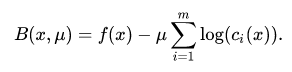

In [727]:
def hessian(f):
    return jacfwd(grad(f))

def jacobian(f):
    return jacfwd(f)

def f(x):
    """ the function to be actually minimised"""
    return -jnp.sum(x)

def C(x):
    """ the constraint function"""
    constraints = [(x[0]*p*2+x[1]-p**2-1) for p in jnp.arange(0.,1.,0.1)] # h(x) <= 0
    lowerbounds = [-x[0],-x[1]]   # -x<=0
    return jnp.array(constraints+lowerbounds)

def psi(x):
    """barrier function"""
    return -1*jnp.sum(jnp.log(-C(x)))

def B(x):
    """ new optimisation probelm"""
    return f(x) + mu * psi(x)


    
g_b = grad(B)
g = grad(f)
H = hessian(B)

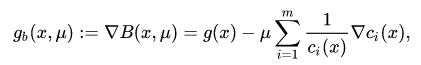

In [ ]:
# n = 2, m = 12

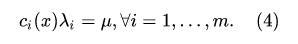

In [728]:
A = jacobian(C)
W = hessian(B)

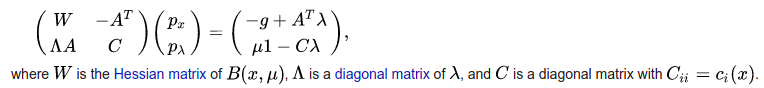

Express this as the form Q.P = R

[  [2,2]   [2,10] ]   [2]  =  [  ]
[ [10,2] , [10,10] ]  [10]

[10x10] x [10,2]

In [977]:
x = np.array([0.1,0.1])
L = mu/C(x) # lambda jnp.ones(C(x).shape[0])
mu=0.1

In [978]:
n = x.shape[0]
m = L.shape[0]
nv = n+m
alpha=0.2  # step size param. What can we do to get rid of this and ensure robustness?

In [979]:
print ('x:',view_jax(x), 'L: ', L.min(), L.max(), L.mean(), 'sigma: ', sigma, 'mu: ', mu, 'gap: ', gap)
for _ in range(25):
    Q = jnp.concatenate([
        jnp.concatenate([W(x),-1*A(x).T], axis=1),
        jnp.concatenate([jnp.dot(jnp.diag(L),A(x)), jnp.diag(C(x))], axis=1),
    ])
    R = jnp.concatenate([
        (-g(x)+jnp.dot(A(x).T,L)),
        (mu - jnp.dot(jnp.diag(C(x)),L))
    ])
    
    P = jnp.dot(jnp.linalg.inv(Q),R)
    
    # find the largest alpha stepsize, see matlab below
    
    gap = jnp.dot(C(x),L)
    
    sigma = jnp.sqrt(jnp.linalg.norm(R) / nv)
    
    x += alpha*P[0:2]
    L += alpha*P[2:]
    mu = sigma*gap /m
    print ('x:',view_jax(x), 'L: ', L.min(), L.max(), L.mean(), 'sigma: ', sigma, 'mu: ', mu, 'gap: ', gap)

x: ['0.1000', '0.1000'] L:  -0.0052284575 -0.00034172923 -0.0012831202 sigma:  0.10081294 mu:  0.1 gap:  0.062235553
x: ['0.1219', '0.1179'] L:  -0.203247 -0.01335808 -0.049948744 sigma:  0.32256287 mu:  0.00016865064 gap:  0.0062741498
x: ['0.2236', '0.2140'] L:  -0.021756483 0.0066162646 -0.014864198 sigma:  0.32262444 mu:  0.0066196336 gap:  0.24621692
x: ['0.5954', '0.4362'] L:  -0.032213204 -0.0068382276 -0.024837485 sigma:  0.2886953 mu:  0.0037758176 gap:  0.15694682
x: ['0.5955', '0.5496'] L:  -0.04484725 -0.0054240865 -0.03164535 sigma:  0.27476287 mu:  0.0021983976 gap:  0.09601287
x: ['0.5735', '0.6220'] L:  -0.061584894 -0.0044251145 -0.037859812 sigma:  0.2580491 mu:  0.0016376149 gap:  0.07615364
x: ['0.5568', '0.6625'] L:  -0.08217999 -0.0037784707 -0.042936873 sigma:  0.24197347 mu:  0.0012579669 gap:  0.062385358
x: ['0.5449', '0.6871'] L:  -0.1078803 -0.0032622523 -0.047042966 sigma:  0.22794682 mu:  0.0009952598 gap:  0.052394316
x: ['0.5362', '0.7029'] L:  -0.139959

**With back-off**

      ls     = ls + 1;
      xnew   = x + alpha * px;
      znew   = z + alpha * pz;
      f      = objective(xnew);
      c      = constraints(xnew);
      psinew = merit(xnew,znew,f,c,mu,eps);
      
      % Stop backtracking search if we've found a candidate point that
      % sufficiently decreases the merit function and satisfies all the
      % constraints.
      if sum(c > 0) == 0 & psinew < psi + tau*eta*alpha*dpsi
	x     = xnew;
	z     = znew;
	gprev = g;

In [996]:
x = np.array([0.1,0.1])
mu=0.1
L = mu/C(x) # lambda jnp.ones(C(x).shape[0])

In [997]:
n = x.shape[0]
m = L.shape[0]
nv = n+m
#alpha=0.2  # step size param. What can we do to get rid of this and ensure robustness?
beta=0.75
tau = 0.01
etamax=0.25

In [998]:
print ('x:',view_jax(x), 'L: ', L.min(), L.max(), L.mean(), 'sigma: ', sigma, 'mu: ', mu, 'gap: ', gap)
for _ in range(25):
    alpha = 1.
    
    Q = jnp.concatenate([
        jnp.concatenate([W(x),-1*A(x).T], axis=1),
        jnp.concatenate([jnp.dot(jnp.diag(L),A(x)), jnp.diag(C(x))], axis=1),
    ])
    R = jnp.concatenate([
        (-g(x)+jnp.dot(A(x).T,L)),
        (mu - jnp.dot(jnp.diag(C(x)),L))
    ])
    
    P = jnp.dot(jnp.linalg.inv(Q),R)
    
    # find the largest alpha stepsize, see matlab below
    
    gap = jnp.dot(C(x),L)
    
    eta   = min(etamax,jnp.linalg.norm(R)/nv);
    sigma = jnp.sqrt(jnp.linalg.norm(R) / nv)
    
    merit=B(x)
    dmerit = g_b(x)
    
    i=0
    
    while True:
        
        x_new = x + alpha*P[0:2]
        L_new = L + alpha*P[2:]
        
        c_new = C(x_new)
        merit_new = B(x_new)
        dmerit = g_b(x_new)
        
        if (((c_new < 0).all()) & (merit_new < (merit + tau*eta*alpha*jnp.dot(dmerit,P[0:2])))):
            break
        else:
            i+=1
            alpha = alpha*beta
            
            if i>=20:
                break
    
    x += alpha*P[0:2]
    L += alpha*P[2:]
    mu = sigma*gap /m
    print ('x:',view_jax(x), 'L: ', L.min(), L.max(), L.mean(),'alpha: ',alpha, 'sigma: ', sigma, 'mu: ', mu, 'gap: ', gap)

x: ['0.1000', '0.1000'] L:  -1.0 -0.06535947 -0.24541084 sigma:  0.01448595 mu:  0.1 gap:  3.123955e-05
x: ['0.1550', '0.1450'] L:  -0.55020714 -0.07151287 -0.1685429 alpha:  1.0 sigma:  0.34108678 mu:  0.034108683 gap:  1.2000002
x: ['0.3043', '0.2505'] L:  -0.066712014 0.21281439 -0.017162494 alpha:  1.0 sigma:  0.24524549 mu:  0.023341773 gap:  1.1421261
x: ['0.3285', '0.8526'] L:  -0.4254337 -0.0213072 -0.11007631 alpha:  0.75 sigma:  0.1692823 mu:  0.0046586893 gap:  0.33024287
x: ['0.4384', '0.8001'] L:  -0.18766063 -0.0029385611 -0.07303703 alpha:  1.0 sigma:  0.2267209 mu:  0.008946056 gap:  0.4735014
x: ['0.4548', '0.7783'] L:  -0.7969028 -0.012041938 -0.2103483 alpha:  1.0 sigma:  0.14501871 mu:  0.0008070455 gap:  0.06678136
x: ['0.4794', '0.7636'] L:  -0.460331 -0.0006833188 -0.079199955 alpha:  1.0 sigma:  0.3691845 mu:  0.0037039153 gap:  0.12039234
x: ['0.4943', '0.7477'] L:  -0.46537793 -0.0048769442 -0.09784278 alpha:  1.0 sigma:  0.07418745 mu:  0.00011151133 gap:  0.

**Matlab implementation:**

https://pcarbo.github.io/convexprog.html

In [64]:
def hessian(f):
    return jacfwd(grad(f))

def jacobian(f):
    return jacfwd(f)

def f(x):
    """ the function to be actually minimised"""
    return -jnp.sum(x)

def C(x):
    """ the constraint function"""
    constraints = [(x[0]*p*2+x[1]-p**2-1) for p in jnp.arange(0.,1.,0.1)] # h(x) <= 0
    lowerbounds = [-x[0],-x[1]]   # -x<=0
    return jnp.array(constraints+lowerbounds)

def psi(x):
    """barrier function"""
    return -1*jnp.sum(jnp.log(-1*C(x)))

def B(x):
    """ new optimisation probelm"""
    return f(x) + mu * psi(x)
    
g = grad(B)
H = hessian(B)

Matlab code:

% X = IPSOLVER(X0,OBJ,GRAD,CONSTR,JACOBIAN,DESCENTDIR,TOL,MAXITER,VERBOSE)
% is a simple yet reasonably robust implementation of a primal-dual
% interior-point solver for convex programs with convex inequality
% constraints (it does not handle equality constraints). Precisely speaking,
% it will compute the solution to the following optimization problem:
%
%     minimize    f(x)
%     subject to  c(x) < 0,
%
% where f(x) is a convex objective and c(x) is a vector-valued function with
% outputs that are convex in x. There are many, many optimization problems
% that can be framed in this form (see the book "Convex Optimization" by
% Boyd and Vandenberghe for a good start). This code is mostly based on
% the descriptions provided in this reference:
%
%    Paul Armand, Jean C. Gilbert, Sophie Jan-Jegou. A Feasible BFGS
%    Interior Point Algorithm for Solving Convex Minimization Problems. 
%    SIAM Journal on Optimization, Vol. 11, No. 1, pp. 199-222.
%
% However, to understand what is going on you will need to read up on
% interior-point methods for constrained optimization. A good starting
% point is the book of Boyd and Vandenberghe.
%
% The input X0 is the initial point for the solver. It must be an n x 1
% matrix, where n is the number of (primal) optimization variables.
% DESCENTDIR must be either: 'newton' for the Newton search direction,
% 'bfgs' for the quasi-Newton search direction with the
% Broyden-Fletcher-Goldfarb-Shanno (BFGS) update, or 'steepest' for the
% steepest descent direction. The steepest descent direction is often quite
% bad, and the solver may fail to converge to the solution if you take this
% option. For the Newton direction, you must be able to compute the the
% Hessian of the objective. Also note that we form a quasi-Newton
% approximation to the objective, not to the Lagrangian (as is usually
% done). This means that you will always have to provide second-order
% information about the inequality constraint functions.
% 
% TOL is the tolerance of the convergence criterion; it determines when the
% solver should stop. MAXITER is the maximum number of iterations. And the
% final input, VERBOSE, must be set to true or false depending on whether
% you would like to see the progress of the solver.
%
% The inputs OBJ, GRAD, CONSTR and JACOBIAN must all be function handles. If
% you don't know what function handles are, type HELP FUNCTION_HANDLE in
% MATLAB.
% 
%    * OBJ must be a handle to a function that takes 1 input, the vector
%      of optimization variables, and returns the value of the function at
%      the given point. The function definition should look something like F
%      = OBJECTIVE(X).
%
%    * GRAD is a pointer to a function of the form G = GRADIENT(X), where
%      G is the n x 1 gradient vector of the objective, or [G H] =
%      GRADIENT(X) if the Newton step is used, in which case H is the n x n
%      Hessian of the objective.
%
%    * CONSTR is a handle to a function of the form C = CONSTRAINTS(X),
%      where C is the m x 1 vector of constraint responses at X.
%
%    * JACOBIAN is a handle to a function of the form [J W] =
%      JACOBIAN(X,Z). The inputs are the primal variables X and the m x 1
%      vector of dual variables Z. The return values are the m x n
%      Jacobian matrix (containing the first-order partial derivatives
%      of the inequality constraint functions), and W is the n x n
%      Hessian of the Lagrangian (minus the Hessian of the objective), 
%      which is basically equal to
%
%          W = z(1)*W1 + z(2)*W2 + ... + z(m)*Wm,
%
%      where Wi is the Hessian of the ith constraint.
%
% If you set VERBOSE to true, then at each iteration the solver will output
% the following information (from left to right): 1. the iteration number,
% 2. the value of the objective, 3. the barrier parameter mu, 4. the
% centering parameter sigma, 4. the residuals of the perturbed
% Karush-Kuhn-Tucker system (rx, rc), 5. the step size, and the number of
% iterations in the line search before we found a suitable descent step.
%
% If your optimization problem is large (i.e. it involves a lot of
% optimization variables or inequality constraints) it might speed up the
% solver to output sparse matrices. (Type HELP SPARSE in the MATLAB console
% for more information on sparse matrices.)
%
% As a final note, the interior-point solver may not work very well if your
% problem is very poorly scaled (i.e. the Hessian of the objective or the
% Hessian of one of the constraint functions is poorly conditioned). It
% is up to you to make sure you look at the conditioning of your problem.
%
%                                         Peter Carbonetto
%                                         Dept. of Computer Science
%                                         University of British Columbia
%                                         Copyright 2008
%
function x = ipsolver (x, objective, gradient, constraints, jacobian, ...
		       descentdir, tolerance, maxiter, verbose)

  % Some algorithm parameters.
  eps       = 1e-8;   % A number close to zero.
  sigmamax  = 0.5;    % The maximum centering parameter.
  etamax    = 0.25;   % The maximum forcing number.
  mumin     = 1e-9;   % Minimum barrier parameter.
  alphamax  = 0.995;  % Maximum step size.
  alphamin  = 1e-6;   % Minimum step size.
  beta      = 0.75;   % Granularity of backtracking search.
  tau       = 0.01;   % Amount of actual decrease we will accept in 
                      % line search.

  % INITIALIZATION.  
  % Get the number of primal variables (n), the number of constraints (m),
  % and the total number of primal-dual optimization variables (nv).
  % Initialize the Lagrange multipliers. Initialize the second-order
  % information.
  c  = constraints(x);
  n  = length(x);
  m  = length(c);
  nv = n + m;
  z  = ones(m,1);
  B  = eye(n);
  
  if verbose
    fprintf('  i f(x)       lg(mu) sigma   ||rx||  ||rc||  alpha   #ls\n');
  end
  
  % Repeat while the convergence criterion has not been satisfied, and
  % we haven't reached the maximum number of iterations.
  alpha = 0;
  ls    = 0;
  for iter = 1:maxiter

    % COMPUTE OBJECTIVE, GRADIENT, CONSTRAINTS, ETC.  
    % Compute the response of the objective function, the gradient of the
    % objective, the response of the inequality constraints, the Jacobian of
    % the inequality constraints, the Hessian of the Lagrangian (minus the
    % Hessian of the objective) and, optionally, the Hessian of the
    % objective.
    f     = objective(x);
    c     = constraints(x);
    [J W] = jacobian(x,z);
    if strcmp(descentdir,'newton')
      [g B] = gradient(x);
    else
      g = gradient(x);
    end
    
    % Compute the responses of the unperturbed Karush-Kuhn-Tucker
    % optimality conditions.
    rx = g + J'*z;  % Dual residual.
    rc = c.*z;      % Complementarity.
    r0 = [rx; rc]; 
    
    % Set some parameters that affect convergence of the primal-dual
    % interior-point method.
    eta        = min(etamax,norm(r0)/nv);
    sigma      = min(sigmamax,sqrt(norm(r0)/nv));
    dualitygap = -c'*z;
    mu         = max(mumin,sigma*dualitygap/m);
    
    % Print the status of the algorithm.
    if verbose
      fprintf('%3d %+0.3e  %+5.2f %0.1e %0.1e %0.1e %0.1e %3d\n',...
	      iter,f,log10(mu),sigma,norm(rx),norm(rc),alpha,ls);
    end

    % CONVERGENCE CHECK.
    % If the norm of the responses is less than the specified tolerance,
    % we are done. 
    if norm(r0)/nv < tolerance
      break
    end
    
    % Update the BFGS approximation to the Hessian of the objective.
    if strcmp(descentdir,'bfgs') & iter > 1
      B = bfgsupdate(B,alpha*px,g-gprev);
    end

    % SOLUTION TO PERTURBED KKT SYSTEM.
    % Compute the search direction of x and z.
    S  = diag(sparse(z./(c-eps)));
    gb = g - mu*J'*(1./(c-eps));
    px = (B + W - J'*S*J) \ (-gb);
    pz = -(z + mu./(c-eps) + S*J*px);
    
    % BACKTRACKING LINE SEARCH.
    % To ensure global convergence, execute backtracking line search to
    % determine the step length. First, we have to find the largest step
    % size which ensures that z remains feasible. Next, we perform
    % backtracking line search.
    alpha = alphamax;
    is    = find(z + pz < 0);
    if length(is)
      alpha = alphamax * min(1,min(z(is) ./ -pz(is)));
    end
    
    % Compute the response of the merit function and the directional
    % gradient at the current point and search direction.
    psi  = merit(x,z,f,c,mu,eps);
    dpsi = gradmerit(x,z,px,pz,g,c,J,mu,eps);
    ls   = 0;
    while true

      % Compute the candidate point, the constraints, and the response of
      % the objective function and merit function at the candidate point.
      ls     = ls + 1;
      xnew   = x + alpha * px;
      znew   = z + alpha * pz;
      f      = objective(xnew);
      c      = constraints(xnew);
      psinew = merit(xnew,znew,f,c,mu,eps);
      
      % Stop backtracking search if we've found a candidate point that
      % sufficiently decreases the merit function and satisfies all the
      % constraints.
      if sum(c > 0) == 0 & psinew < psi + tau*eta*alpha*dpsi
	x     = xnew;
	z     = znew;
	gprev = g;
	break
      end
      
      % The candidate point does not meet our criteria, so decrease the step
      % size for 0 < beta < 1.
      alpha = alpha * beta;
      if alpha < alphamin
	error('Step size too small');
      end
    end
  end
  
% ------------------------------------------------------------------
% Compute the response of the merit function at (x,z).
function psi = merit (x, z, f, c, mu, eps)
  psi = f - c'*z - mu*sum(log(c.^2.*z+eps));
  
% ------------------------------------------------------------------
% Compute the directional derivative of the merit function at (x,z).
function dpsi = gradmerit (x, z, px, pz, g, c, J, mu, eps)
  dpsi = px'*(g - J'*z - 2*mu*J'*(1./(c-eps))) - pz'*(c + mu./(z+eps));

% ------------------------------------------------------------------
% Update the quasi-Newton approximation using Broyden-Fletcher-
% Goldfarb-Shanno (BFGS) formula.
function B = bfgsupdate (B, s, y)  
  if y'*s < 0
    error('dot(y,s) > 0 is not satisfied');
  end
  x = B*s;
  B = B - x*x'/(x'*s) + y*y'/(y'*s);
  